<a href="https://colab.research.google.com/github/cepdnaclk/e18-4yp-Predicting-Forex-Currency-Exchange-Rate-using-Machine-Learning/blob/main/IN1_LSTM_Bayesian_Version1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas_ta
!pip install bayesian-optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=99c1a11f4bcade48f7dca6c60db70aa169100bc26e4b9dc9b7e2b4e4b56fc668
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [ ]:
import pandas as pd
import pandas_ta as ta

data = pd.read_csv('LKR=X.csv')
data


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-05-31,173.419998,176.449997,173.419998,176.300003,176.300003,0
1,2019-06-03,172.809998,176.490005,172.809998,172.449997,172.449997,0
2,2019-06-04,172.520004,176.509995,172.520004,176.440002,176.440002,0
3,2019-06-05,173.380005,176.399994,173.380005,176.350006,176.350006,0
4,2019-06-06,173.809998,176.350006,173.809998,176.360001,176.360001,0
...,...,...,...,...,...,...,...
1301,2024-05-27,296.123901,297.297058,296.123901,295.987457,295.987457,0
1302,2024-05-28,297.227264,298.504425,297.227264,297.297058,297.297058,0
1303,2024-05-29,299.508514,299.508514,298.592590,299.327850,299.327850,0
1304,2024-05-30,299.668427,299.668427,298.626251,298.592590,298.592590,0


In [ ]:
data['T-4'] = data['Close']
data['T-3'] = data['Close'].shift(-1)
data['T-2'] = data['Close'].shift(-2)
data['T-1'] = data['Close'].shift(-3)
data['T0'] = data['Close'].shift(-4)

data['SMA_5_H'] = ta.sma(data['High'], length=5).shift(-4)
data['SMA_5_L'] = ta.sma(data['Low'], length=5).shift(-4)
data['EMA_5_C'] = ta.ema(data['Close'], length=5).shift(-4)
data['RSI'] = ta.rsi(data['Close'], length=14).shift(-14)

#Closing value of the next day
data['T_F'] = data['Close'].shift(-5)

In [ ]:
print(data.tail(10))

            Date        Open        High         Low       Close   Adj Close  \
1296  2024-05-20  295.506714  296.635529  295.506714  294.929016  294.929016   
1297  2024-05-21  296.688782  296.796051  296.688782  296.739319  296.739319   
1298  2024-05-22  296.992859  296.992859  296.874847  296.796051  296.796051   
1299  2024-05-23  297.043518  297.043518  296.886108  296.874847  296.874847   
1300  2024-05-24  297.840454  297.840454  296.466858  296.886108  296.886108   
1301  2024-05-27  296.123901  297.297058  296.123901  295.987457  295.987457   
1302  2024-05-28  297.227264  298.504425  297.227264  297.297058  297.297058   
1303  2024-05-29  299.508514  299.508514  298.592590  299.327850  299.327850   
1304  2024-05-30  299.668427  299.668427  298.626251  298.592590  298.592590   
1305  2024-05-31  301.350006  301.640015  301.220001  301.329987  301.329987   

      Volume         T-4         T-3         T-2         T-1          T0  \
1296       0  294.929016  296.739319  296.7

In [ ]:
# Dropping NaN values
data.dropna(inplace=True)

print(data.tail(10))


            Date        Open        High         Low       Close   Adj Close  \
1282  2024-04-30  294.208221  294.208221  293.375488  294.090210  294.090210   
1283  2024-05-01  295.085663  295.217194  294.853363  293.375488  293.375488   
1284  2024-05-02  293.709625  293.917816  293.709625  294.853363  294.853363   
1285  2024-05-03  293.085205  293.881195  293.085205  293.917816  293.917816   
1286  2024-05-06  293.332581  293.715454  293.332581  293.463409  293.463409   
1287  2024-05-07  293.626862  296.502350  293.626862  293.715454  293.715454   
1288  2024-05-08  297.038910  297.067932  297.038910  296.502350  296.502350   
1289  2024-05-09  297.171631  297.171631  295.473602  297.067932  297.067932   
1290  2024-05-10  294.186676  295.699127  294.186676  295.473602  295.473602   
1291  2024-05-13  295.998444  296.051788  295.826752  295.924255  295.924255   

      Volume         T-4         T-3         T-2         T-1          T0  \
1282       0  294.090210  293.375488  294.8

In [ ]:
data = data[['Date', 'T-4','T-3','T-2','T-1','T0','SMA_5_H','SMA_5_L','EMA_5_C','RSI','T_F']]

data

,Date,T-4,T-3,T-2,T-1,T0,SMA_5_H,SMA_5_L,EMA_5_C,RSI,T_F
0,2019-05-31,176.300003,172.449997,176.440002,176.350006,176.360001,176.439999,173.188001,175.580002,52.979559,176.339996
1,2019-06-03,172.449997,176.440002,176.350006,176.360001,176.339996,176.429999,173.036002,175.833333,53.177859,176.350006
2,2019-06-04,176.440002,176.350006,176.360001,176.339996,176.350006,176.423999,172.984003,176.005557,52.937432,176.360001
3,2019-06-05,176.350006,176.360001,176.339996,176.350006,176.360001,176.412000,173.114002,176.123705,51.515911,176.360001
4,2019-06-06,176.360001,176.339996,176.350006,176.360001,176.360001,176.442001,173.072000,176.202471,51.341348,176.419998
...,...,...,...,...,...,...,...,...,...,...,...
1287,2024-05-07,293.715454,296.502350,297.067932,295.473602,295.924255,296.498566,295.230560,295.650012,47.739295,296.051788
1288,2024-05-08,296.502350,297.067932,295.473602,295.924255,296.051788,296.843109,295.686188,295.783937,53.208312,298.225067
1289,2024-05-09,297.067932,295.473602,295.924255,296.051788,298.225067,297.156110,295.817273,296.597647,60.169194,298.632935
1290,2024-05-10,295.473602,295.924255,296.051788,298.225067,298.632935,297.230341,296.077960,297.276076,56.870495,297.542786


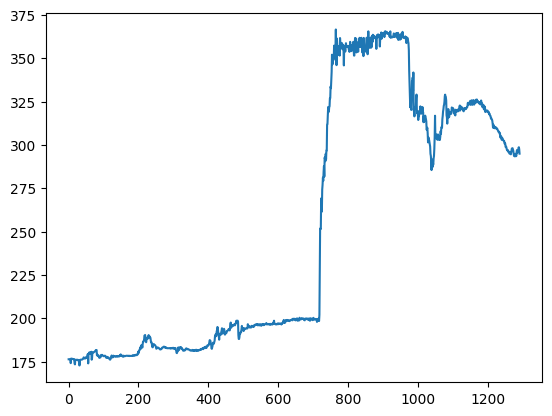

In [ ]:
import matplotlib.pyplot as plt

plt.plot(data.index, data['T_F'])

In [ ]:
dates=data['Date'].to_numpy()
middle_matrix = data[['T-4','T-3','T-2','T-1','T0','SMA_5_H','SMA_5_L','EMA_5_C','RSI']].to_numpy()
X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
Y=data['T_F']

print(dates.shape)
print(X.shape)
print(Y.shape)

(1292,)
(1292, 9, 1)
(1292,)


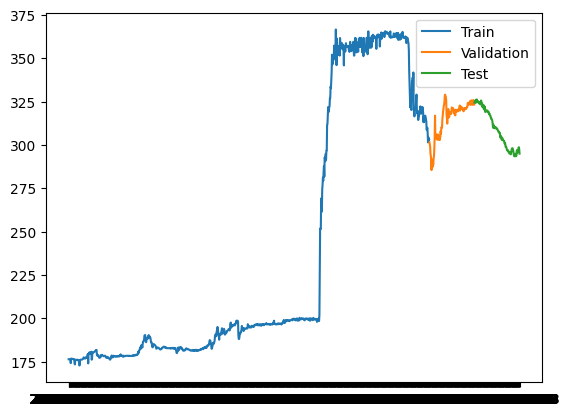

In [ ]:
q_80 = int(len(dates) * .8) #change to 0.8
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], Y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], Y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], Y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
import numpy as np
import time

def evaluate_network(lstm_units_1,epochs,learning_rate,dense_units_1,dense_units_2,dense_units_3):

  lstm_units_1=int(lstm_units_1)
  epochs=int(epochs)
  dense_units_1=int(dense_units_1)
  dense_units_2=int(dense_units_2)
  dense_units_3=int(dense_units_3)

  model = Sequential([layers.Input((11, 1)),
                      layers.LSTM(lstm_units_1),
                      layers.Dense(dense_units_1, activation='relu'),
                      layers.Dense(dense_units_2, activation='relu'),
                      layers.Dense(dense_units_3, activation='relu'),
                      layers.Dense(1)])

  model.compile(loss='mse',
                optimizer=Adam(learning_rate=learning_rate),
                metrics=['mean_absolute_error'])


  # Train the model
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, verbose=0)

  # Return the loss (or another metric that you want to minimize)
  val_loss=min(history.history['val_loss'])
  loss=min(history.history['loss'])

  return -(val_loss*loss)  # Negative because BayesianOptimization maximizes, but we want to minimize loss



pbounds = {
    'lstm_units_1': (20, 300),
    'learning_rate': (1e-6, 1e-2),
    'epochs': (10, 300),
    'dense_units_1': (10, 200),
    'dense_units_2': (10, 200),
    'dense_units_3': (10, 200)
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=evaluate_network,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
    )

# Run the optimization
start_time = time.time()
optimizer.maximize(init_points=12, n_iter=12)
time_took = (time.time() - start_time)/60


# Get the best hyperparameters
print(f"Total runtime in mins: {time_took}")
best_params = optimizer.max['params']
print(f"Best hyperparameters: {best_params}")



|   iter    |  target   | dense_... | dense_... | dense_... |  epochs   | learni... | lstm_u... |
-------------------------------------------------------------------------------------------------
| 1         | -240.8    | 89.23     | 146.9     | 10.02     | 97.68     | 0.001468  | 45.85     |
| 2         | -208.5    | 45.39     | 75.66     | 85.39     | 166.3     | 0.004193  | 211.9     |
| 3         | -175.2    | 48.85     | 176.8     | 15.2      | 204.4     | 0.004174  | 176.4     |
| 4         | -120.6    | 36.67     | 47.64     | 162.1     | 290.8     | 0.003135  | 213.9     |
| 5         | -370.8    | 176.5     | 180.0     | 26.16     | 21.33     | 0.001699  | 265.9     |
| 6         | -8.474e+0 | 28.69     | 90.01     | 192.0     | 164.6     | 0.006919  | 108.3     |
| 7         | -3.699e+0 | 140.4     | 168.6     | 13.47     | 227.5     | 0.009889  | 229.5     |
| 8         | -1.921e+0 | 63.28     | 160.0     | 29.61     | 139.9     | 0.009086  | 102.2     |
| 9         | -182.5

KeyboardInterrupt: 

Epoch 1/131
33/33 [==============================] - 5s 21ms/step - loss: 60192.4883 - mean_absolute_error: 233.8289 - val_loss: 97407.8359 - val_mean_absolute_error: 311.9291
Epoch 2/131
33/33 [==============================] - 0s 6ms/step - loss: 57411.1406 - mean_absolute_error: 227.7529 - val_loss: 90686.7500 - val_mean_absolute_error: 300.9597
Epoch 3/131
33/33 [==============================] - 0s 6ms/step - loss: 46864.8945 - mean_absolute_error: 202.5133 - val_loss: 65837.5938 - val_mean_absolute_error: 256.3618
Epoch 4/131
33/33 [==============================] - 0s 6ms/step - loss: 24275.2812 - mean_absolute_error: 133.8879 - val_loss: 29054.5859 - val_mean_absolute_error: 170.1218
Epoch 5/131
33/33 [==============================] - 0s 6ms/step - loss: 8656.9893 - mean_absolute_error: 62.5746 - val_loss: 9481.9668 - val_mean_absolute_error: 96.8090
Epoch 6/131
33/33 [==============================] - 0s 6ms/step - loss: 5663.6421 - mean_absolute_error: 65.6653 - val_loss: 64

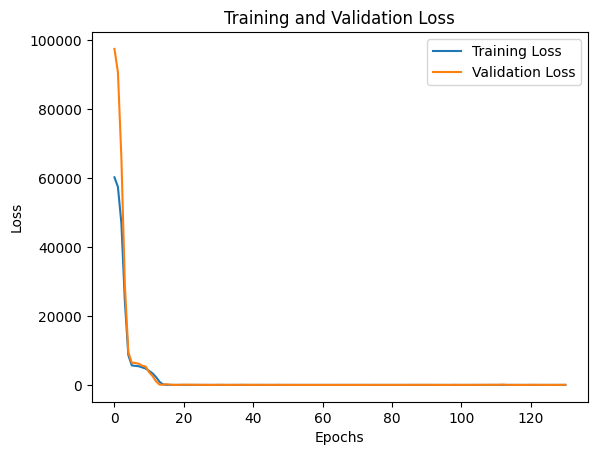

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# model = Sequential([layers.Input((9, 1)),
#                     layers.LSTM(64),
#                     layers.Dense(1)])
model = Sequential([layers.Input((9, 1)),
                   layers.LSTM(208),
                   layers.Dense(75, activation='relu'),
                   layers.Dense(91, activation='relu'),
                   layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0002802),
              metrics=['mean_absolute_error'])


history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=131)

print(history.history.keys())

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Add labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

33/33 [==============================] - 0s 2ms/step


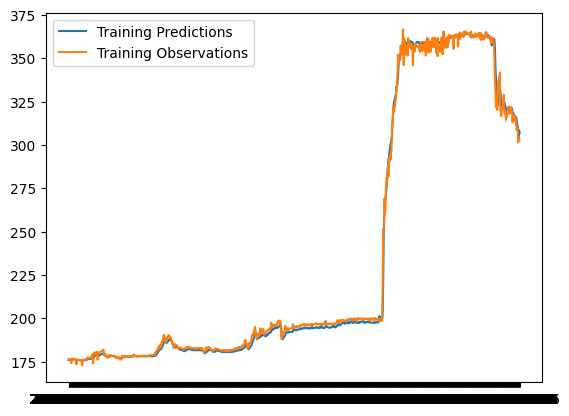

In [ ]:
from sklearn.metrics import mean_squared_error

train_predictions = model.predict(X_train).flatten()
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

188.8254095686106


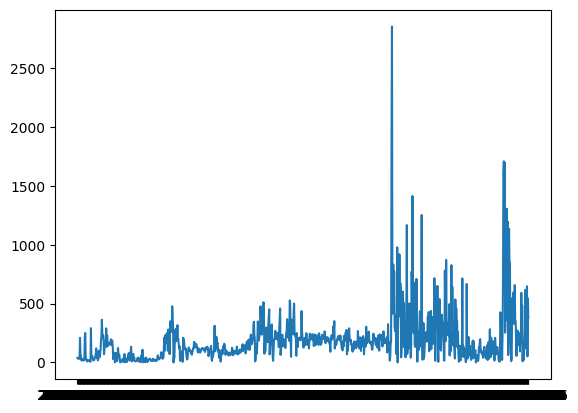

In [ ]:
import numpy as np

basis_point_value=0.01  #For USDLKR pair
train_data_basis_point_diff=((train_predictions/basis_point_value).flatten()-y_train/basis_point_value).abs()
plt.plot(dates_train, train_data_basis_point_diff)

average_train_data_basis_point_diff=np.mean(train_data_basis_point_diff)
print(average_train_data_basis_point_diff)

5/5 [==============================] - 0s 4ms/step


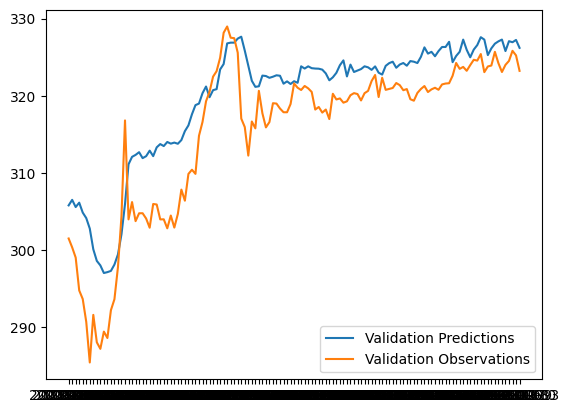

In [ ]:
val_predictions = model.predict(X_val).flatten()
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])


479.7859820978688


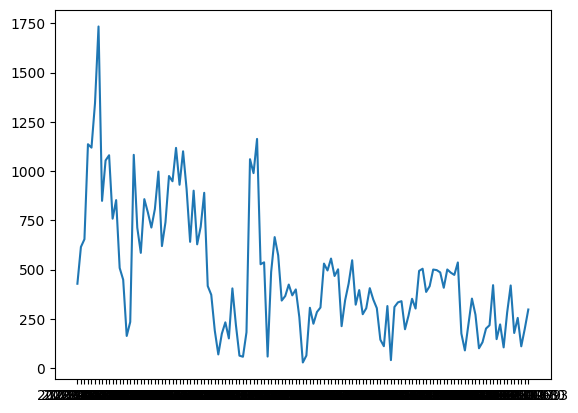

In [ ]:
basis_point_value=0.01  #For USDLKR pair
validation_data_basis_point_diff=((val_predictions/basis_point_value).flatten()-y_val/basis_point_value).abs()
plt.plot(dates_val, validation_data_basis_point_diff)

print(np.mean(validation_data_basis_point_diff))

5/5 [==============================] - 0s 3ms/step


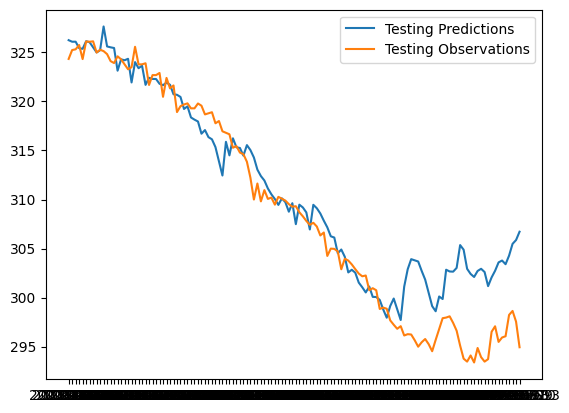

In [ ]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Assuming test_predictions and y_test are lists or numpy arrays
# Calculate MSE and MAE
mse = mean_squared_error(y_test, test_predictions)
print("Mean Square Error:", mse)
mae=mean_absolute_error(y_test, test_predictions)
print("Mean Absolute Error:", mae)

Mean Square Error: 15.73730649066517
Mean Absolute Error: 2.698543862575118


269.85457687499996


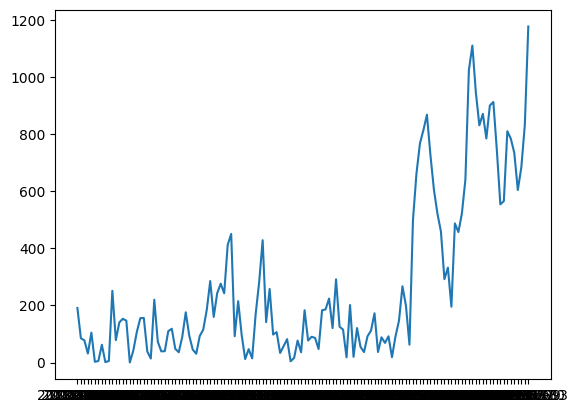

In [ ]:
basis_point_value=0.01  #For USDLKR pair
test_data_basis_point_diff=((test_predictions/basis_point_value).flatten()-y_test/basis_point_value).abs()
plt.plot(dates_test, test_data_basis_point_diff)

print(np.mean(test_data_basis_point_diff))

In [ ]:
#Start Trading with 1000 LKR with model


number_of_trading_days=dates_test.size
test_data=y_test.values
holding_currency="quote"
holding_value=1000
for current_trading_day in range(number_of_trading_days-1):
  if holding_currency=="quote":
    if (test_predictions[current_trading_day+1]>test_data[current_trading_day]):
      holding_value=holding_value/test_data[current_trading_day]
      holding_currency="base"
  else:
    if (test_predictions[current_trading_day+1]<test_data[current_trading_day]):
      holding_value=test_data[current_trading_day]*holding_value
      holding_currency="quote"


if holding_currency=="base":
  holding_value=test_data[current_trading_day]*holding_value

print(number_of_trading_days)
print(holding_value)
print(holding_currency)


130
988.3186484291483
base


In [ ]:
#Start Trading with 1000 USD LKR actual values


number_of_trading_days=dates_test.size
test_data=y_test.values
holding_currency="quote"
holding_value=1000
for current_trading_day in range(number_of_trading_days-1):
  if holding_currency=="quote":
    if (test_data[current_trading_day+1]>test_data[current_trading_day]):
      holding_value=holding_value/test_data[current_trading_day]
      holding_currency="base"
  else:
    if (test_data[current_trading_day+1]<test_data[current_trading_day]):
      holding_value=test_data[current_trading_day]*holding_value
      holding_currency="quote"


if holding_currency=="base":
  holding_value=test_data[current_trading_day]*holding_value

print(number_of_trading_days)
print(holding_value)
print(holding_currency)

130
1110.334441821766
quote


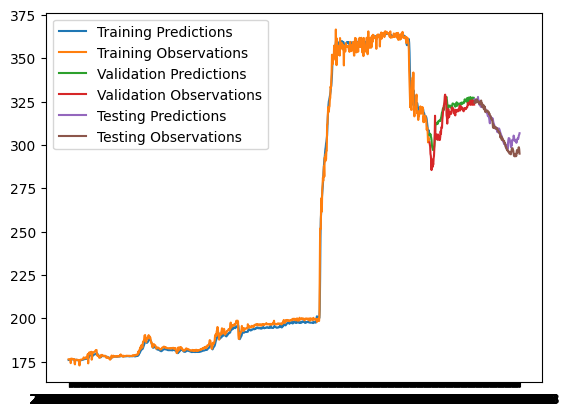

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [ ]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

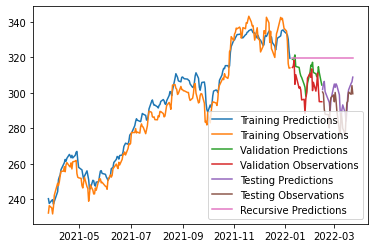

In [ ]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])